# **Partie 2 : étude de faisabilité des features d'images**

Dans le cadre de notre mission en tant que Data Scientist chez "Place de marché", nous avons pour objectif d'automatiser l'attribution des catégories pour les articles proposés sur notre plateforme e-commerce. Actuellement, cette tâche est réalisée manuellement par les vendeurs, ce qui peut engendrer des erreurs et des incohérences. Avec la croissance prévue du volume d'articles, il devient crucial de développer un moteur de classification automatique des articles basé sur leur description textuelle et leur image. Linda, notre Lead Data Scientist, nous a confié la réalisation d'une étude de faisabilité pour ce projet. Cette étude comprendra l'analyse des données textuelles et visuelles, l'extraction de features, et l'évaluation de la possibilité de regrouper les articles par catégorie de manière automatique.

Sommaire :



*   Préparation des données
*   Segmentation des produits via leur image



Numérisation de l'image : approche **Générateur de descripteurs SIFT**

Numérisation de l'image : approche **Réseaux de neurones CNN transfer learning**

Numérisation de l'image : approches supervisées



*   VGG16
*   VGG19
*   RESNET50

Conclusion






# Image : Etape 1

## Préparation du dataset

In [1]:
#Importation des librairies nécessaires pour le projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
data_test = pd.read_csv("/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/data_test.csv")
data_test.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  Home Furnishing >> Curtains & Accessories >> C...  CRNEG7BKMFFYHQ8Z   
1  Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEGFZHGBXPHZUH   
2  Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEG6SHXTDB2A2Y   
3  Home Furnishing >> Bed Linen >> Bedsheets >> S...  BDSEJT9UQWHDUBH4   
4  Home Furnishing >> Bed Linen >> Bedsheets >> J...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product  ...       overall_rating                  brand  \
0                    False  ...  No rating available               Elegance   
1                    False  ...  No rating available               Sathiyas   
2                    False  ...  No rating available                Eurospa   
3                    False  ...  No rating available  SANTOSH ROYAL FASHION   
4                    False  ...  No rating available           Jaipur Print   

                              product_specifications      categorie_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

              categorie_2       categorie_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   
3               Bed Linen         Bedsheets   
4               Bed Linen         Bedsheets   

                                         categorie_4  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   
3                    SANTOSH ROYAL FASHION Bedsheets   
4                             Jaipur Print Bedsheets   

                                         categorie_5 categorie_6 cat_7  
0                                                NaN         NaN   NaN  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...         NaN   NaN  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE ...         NaN   NaN  
3  SANTOSH ROYAL FASHION Cotton Printed King size...         NaN   NaN  
4  Jaipur Print Cotton Floral King sized Double B...         NaN   NaN  

[5 rows x 22 columns]

In [5]:
list_labels = data_test['categorie_1']
list_labels = list(set(list_labels))
list_labels

['Baby Care',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Computers',
 'Beauty and Personal Care',
 'Watches',
 'Home Furnishing']

In [6]:
from sklearn import preprocessing

# Créer un LabelEncoder
le = preprocessing.LabelEncoder()

# Ajuster le LabelEncoder aux valeurs de la colonne 'categorie_1'
le.fit(data_test["categorie_1"])

# Transformer les valeurs de 'categorie_1' en labels numériques et les stocker dans la colonne 'label'
data_test["label"] = le.transform(data_test["categorie_1"])

data_test.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  Home Furnishing >> Curtains & Accessories >> C...  CRNEG7BKMFFYHQ8Z   
1  Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEGFZHGBXPHZUH   
2  Baby Care >> Baby Bath & Skin >> Baby Bath Tow...  BTWEG6SHXTDB2A2Y   
3  Home Furnishing >> Bed Linen >> Bedsheets >> S...  BDSEJT9UQWHDUBH4   
4  Home Furnishing >> Bed Linen >> Bedsheets >> J...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product  ...                  brand  \
0                    False  ...               Elegance   
1                    False  ...               Sathiyas   
2                    False  ...                Eurospa   
3                    False  ...  SANTOSH ROYAL FASHION   
4                    False  ...           Jaipur Print   

                              product_specifications      categorie_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

              categorie_2       categorie_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   
3               Bed Linen         Bedsheets   
4               Bed Linen         Bedsheets   

                                         categorie_4  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                          Sathiyas Baby Bath Towels   
2                           Eurospa Baby Bath Towels   
3                    SANTOSH ROYAL FASHION Bedsheets   
4                             Jaipur Print Bedsheets   

                                         categorie_5 categorie_6 cat_7 label  
0                                                NaN         NaN   NaN     4  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...         NaN   NaN     0  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE ...         NaN   NaN     0  
3  SANTOSH ROYAL FASHION Cotton Printed King size...         NaN   NaN     4  
4  Jaipur Print Cotton Floral King sized Double B...         NaN   NaN     4  

[5 rows x 23 columns]

In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [8]:
data_final = data_test.copy()
data_final = data_final.loc[:,['product_name','image','categorie_1','label']]
data_final = data_final.rename(columns={'categorie_1': 'label_name'})
data_final.head()

product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image       label_name  label  
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing      4  
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care      0  
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care      0  
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing      4  
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing      4

## **Classification des images par catégorie**





In [9]:
import os

drive_path = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations'

#**************************************
# A NE PAS REFAIRE POUR NE PAS CREER DE DOUBLONS

# # Créer les dossiers dans le Drive
# os.mkdir(os.path.join(drive_path, 'Datacat'))
# os.mkdir(os.path.join(drive_path, 'Datacat/train'))
# os.mkdir(os.path.join(drive_path, 'Datacat/test'))


In [10]:
base_dir = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Images copie'
train_dir = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train'
test_dir = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/test'

Création des catégories

In [11]:
cat_array = data_final['label_name'].unique()
cat_array

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [ ]:
#**************************************
# A NE PAS REFAIRE POUR NE PAS CREER DE DOUBLONS

# # Créer les dossiers dans le Drive

# for i in range (len(cat_array)):
#   os.mkdir('/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train/%s' % cat_array[i])
#   os.mkdir('/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/test/%s' % cat_array[i])

In [12]:
import shutil


In [ ]:
# #**************************************
# # A NE PAS REFAIRE POUR NE PAS CREER DE DOUBLONS
# Renomme chaque image en fonction de leurs catégories

# for i in range (len(cat_array)):
#   for j in range(len(data_final['label_name'][data_final['label_name']==cat_array[i]])) :
#     if(j<(len(data_final['label_name'][data_final['label_name']==cat_array[0]])*0.9)):
#       shutil.copy(base_dir+'/%s' % data_final['image'][data_final['label_name']==cat_array[i]].values[j], train_dir +'%s' % cat_array[i])
#       os.rename(train_dir+'/%s' %cat_array[i]+'/'+ data_final['image'][data_final['label_name']==cat_array[i]].values[j], train_dir+'%s' %cat_array[i]+'/'+cat_array[i]+'%i'%j+'.jpg')
#     else :
#       shutil.copy(base_dir+'/%s' % data_final['image'][data_final['label_name']==cat_array[i]].values[j], test_dir +'%s' % cat_array[i])
#       os.rename(test_dir+'/%s' %cat_array[i]+'/'+ data_final['image'][data_final['label_name']==cat_array[i]].values[j], test_dir+'%s' %cat_array[i]+'/'+cat_array[i]+'%i'%j+'.jpg')

In [ ]:
# #**************************************
# # A NE PAS REFAIRE POUR NE PAS CREER DE DOUBLONS
# Sépare en train et test

# for i in range(len(cat_array)):
#     cat_name = cat_array[i]
#     cat_images = data_final[data_final['label_name'] == cat_name]['image'].values
#     n_train = int(len(cat_images) * 0.9)

#     for j in range(len(cat_images)):
#         src_path = os.path.join(base_dir, cat_images[j])

#         if j < n_train:
#             dest_dir = os.path.join(train_dir, cat_name)
#             dest_path = os.path.join(dest_dir, f"{cat_name}{j}.jpg")
#         else:
#             dest_dir = os.path.join(test_dir, cat_name)
#             dest_path = os.path.join(dest_dir, f"{cat_name}{j}.jpg")

#         shutil.copy(src_path, dest_dir)
#         os.rename(os.path.join(dest_dir, cat_images[j]), dest_path)

**Test images**

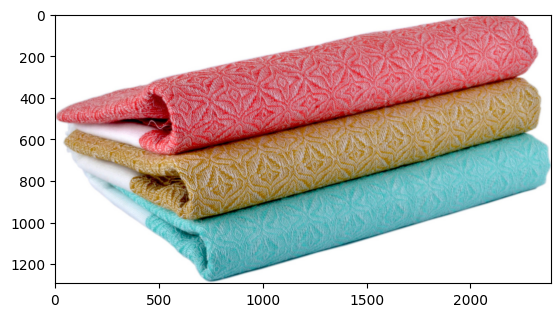

In [13]:
from matplotlib.image import imread

image_baby_care = imread('/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train/Baby Care/Baby Care0.jpg')
plt.imshow(image_baby_care)

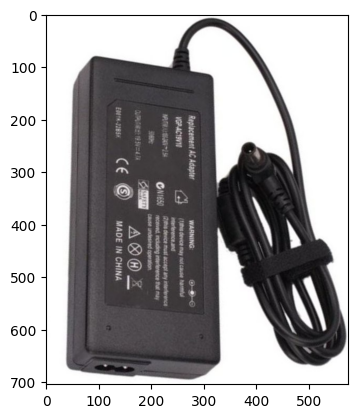

In [ ]:
image_computers = imread('/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train/Computers/Computers100.jpg')
plt.imshow(image_computers)

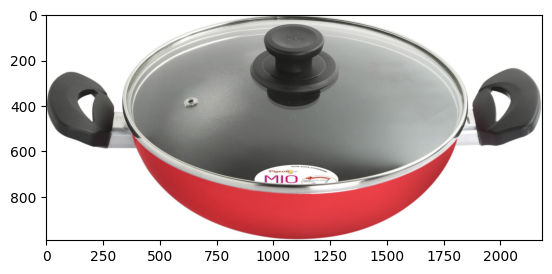

In [ ]:
image_kitchen = imread('/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train/Kitchen & Dining/Kitchen & Dining105.jpg')
plt.imshow(image_kitchen)

**Création des set d'entrainement et de test**

In [14]:
train_dir = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train'
test_dir = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/test'

In [15]:
def collect_images_and_labels(directory):
    image_paths = []
    labels = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for image in os.listdir(category_path):
                image_paths.append(os.path.join(category_path, image))
                labels.append(category)
    return image_paths, labels

train_image_paths, train_labels = collect_images_and_labels(train_dir)
test_image_paths, test_labels = collect_images_and_labels(test_dir)

train_data = pd.DataFrame({'image_path': train_image_paths, 'label_name': train_labels})
test_data = pd.DataFrame({'image_path': test_image_paths, 'label_name': test_labels})

le = preprocessing.LabelEncoder()
train_data["label"] = le.fit_transform(train_data["label_name"])
test_data["label"] = le.transform(test_data["label_name"])

train_data.sample(10)

image_path  \
616  /content/drive/MyDrive/Projet 6 : Classifier a...   
478  /content/drive/MyDrive/Projet 6 : Classifier a...   
741  /content/drive/MyDrive/Projet 6 : Classifier a...   
627  /content/drive/MyDrive/Projet 6 : Classifier a...   
448  /content/drive/MyDrive/Projet 6 : Classifier a...   
870  /content/drive/MyDrive/Projet 6 : Classifier a...   
179  /content/drive/MyDrive/Projet 6 : Classifier a...   
153  /content/drive/MyDrive/Projet 6 : Classifier a...   
11   /content/drive/MyDrive/Projet 6 : Classifier a...   
943  /content/drive/MyDrive/Projet 6 : Classifier a...   

                     label_name  label  
616            Kitchen & Dining      5  
478  Home Decor & Festive Needs      3  
741    Beauty and Personal Care      1  
627            Kitchen & Dining      5  
448  Home Decor & Festive Needs      3  
870                   Computers      2  
179                   Baby Care      0  
153                   Baby Care      0  
11              Home Furnishing      4  
943                   Computers      2

In [ ]:
train_data[train_data["label_name"]=="Home Decor & Festive Needs"]

image_path  \
405  /content/drive/MyDrive/Projet 6 : Classifier a...   
406  /content/drive/MyDrive/Projet 6 : Classifier a...   
407  /content/drive/MyDrive/Projet 6 : Classifier a...   
408  /content/drive/MyDrive/Projet 6 : Classifier a...   
409  /content/drive/MyDrive/Projet 6 : Classifier a...   
..                                                 ...   
535  /content/drive/MyDrive/Projet 6 : Classifier a...   
536  /content/drive/MyDrive/Projet 6 : Classifier a...   
537  /content/drive/MyDrive/Projet 6 : Classifier a...   
538  /content/drive/MyDrive/Projet 6 : Classifier a...   
539  /content/drive/MyDrive/Projet 6 : Classifier a...   

                     label_name  label  
405  Home Decor & Festive Needs      3  
406  Home Decor & Festive Needs      3  
407  Home Decor & Festive Needs      3  
408  Home Decor & Festive Needs      3  
409  Home Decor & Festive Needs      3  
..                          ...    ...  
535  Home Decor & Festive Needs      3  
536  Home Decor & Festive Needs      3  
537  Home Decor & Festive Needs      3  
538  Home Decor & Festive Needs      3  
539  Home Decor & Festive Needs      3  

[135 rows x 3 columns]

In [ ]:
test_data.sample(5)


image_path  \
4   /content/drive/MyDrive/Projet 6 : Classifier a...   
56  /content/drive/MyDrive/Projet 6 : Classifier a...   
73  /content/drive/MyDrive/Projet 6 : Classifier a...   
81  /content/drive/MyDrive/Projet 6 : Classifier a...   
97  /content/drive/MyDrive/Projet 6 : Classifier a...   

                    label_name  label  
4              Home Furnishing      4  
56  Home Decor & Festive Needs      3  
73            Kitchen & Dining      5  
81    Beauty and Personal Care      1  
97                   Computers      2

In [16]:
train_data.groupby("label_name").count()


image_path  label
label_name                                   
Baby Care                          135    135
Beauty and Personal Care           135    135
Computers                          135    135
Home Decor & Festive Needs         135    135
Home Furnishing                    135    135
Kitchen & Dining                   135    135
Watches                            135    135

Baby Care


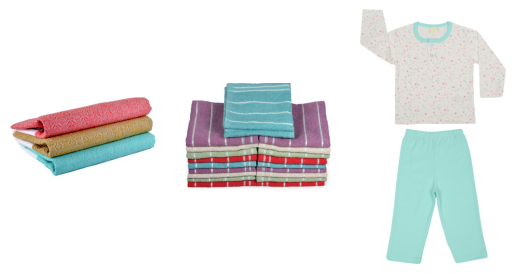

Beauty and Personal Care


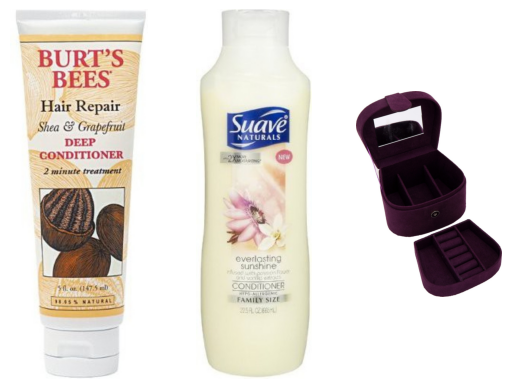

Computers


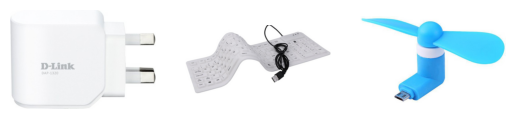

Home Decor & Festive Needs


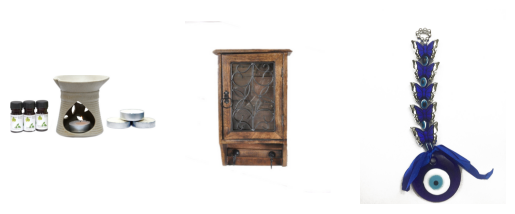

Home Furnishing


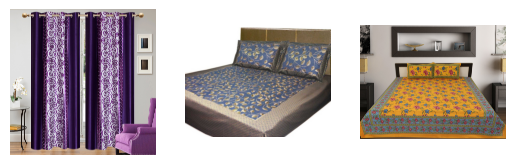

Kitchen & Dining


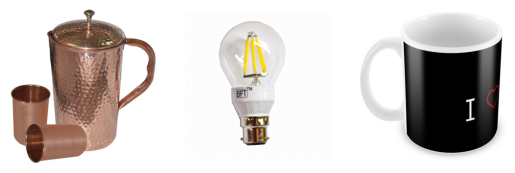

Watches


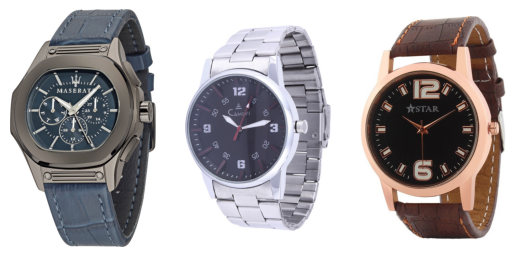

In [ ]:
def list_fct(name, data):
    return [data["image_path"][i] for i in range(len(data)) if data["label_name"][i] == name]


list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

for name in list_labels:
    print(name)
    image_paths = list_fct(name, train_data)
    for i in range(min(3, len(image_paths))):
        plt.subplot(130 + 1 + i)
        image = imread(image_paths[i])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

## Etape 1 : étude de faisabilité avec CNN Learning

### Création du modèle pré-entraîné

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


### Création des features des images

In [ ]:
images_features = []
i=0
for image_file in train_data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


100
200
300
400
500
600


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900


(945, 4096)

### Réduction dimension et analyse V2


In [ ]:
from sklearn import manifold, decomposition


print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = train_data["label_name"]
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (945, 4096)
Dimensions dataset après réduction PCA :  (945, 728)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(945, 3)


In [ ]:
df_tsne.head()

tsne1     tsne2            class
0  34.271240 -0.924452  Home Furnishing
1  32.085186 -7.608603  Home Furnishing
2  41.329277 -3.563574  Home Furnishing
3  36.993172 -1.894162  Home Furnishing
4  37.475452 -3.196978  Home Furnishing

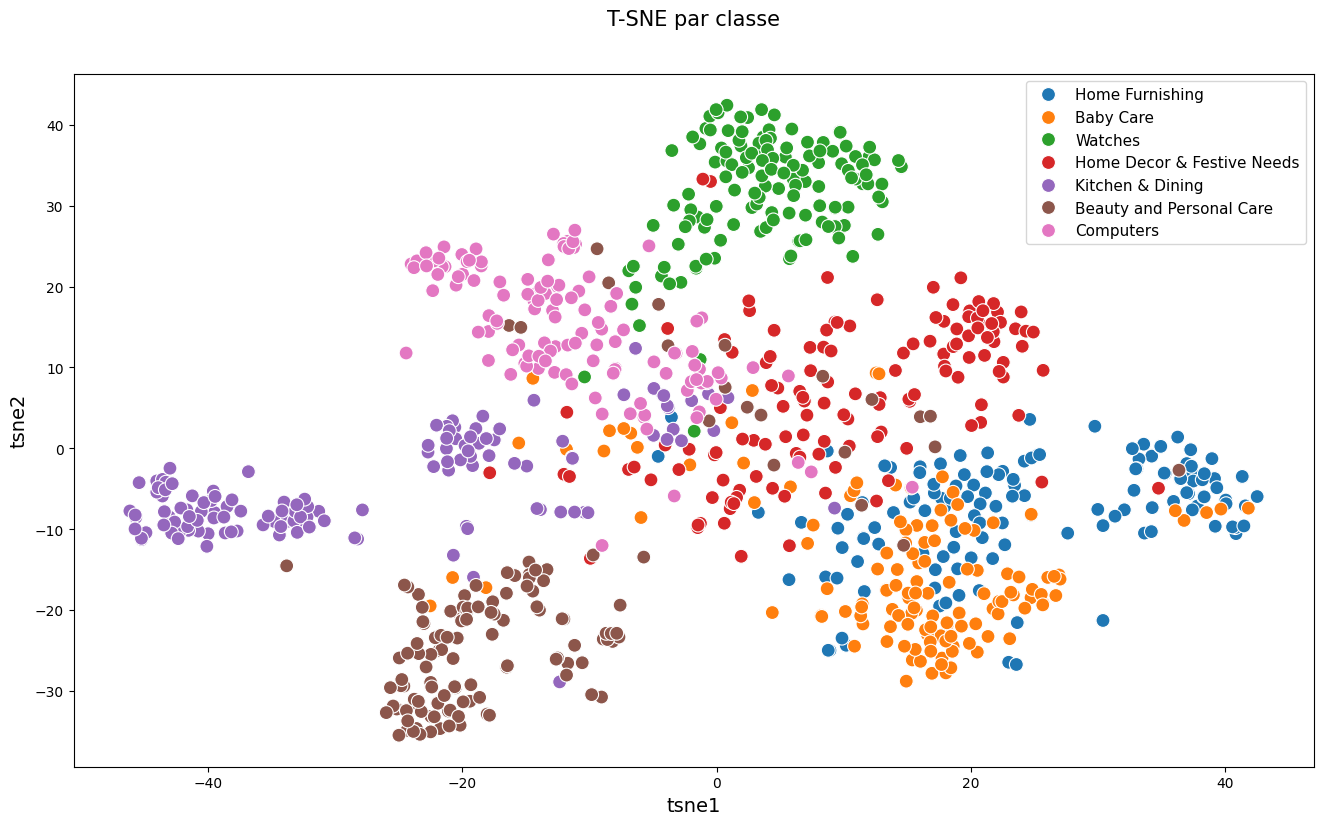

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=100, alpha=1)

plt.title('T-SNE par classe', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11})

plt.show()

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=4, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=4, n_init=100)

(945, 4)


<ipython-input-26-8dc93fbafe3b>:8: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


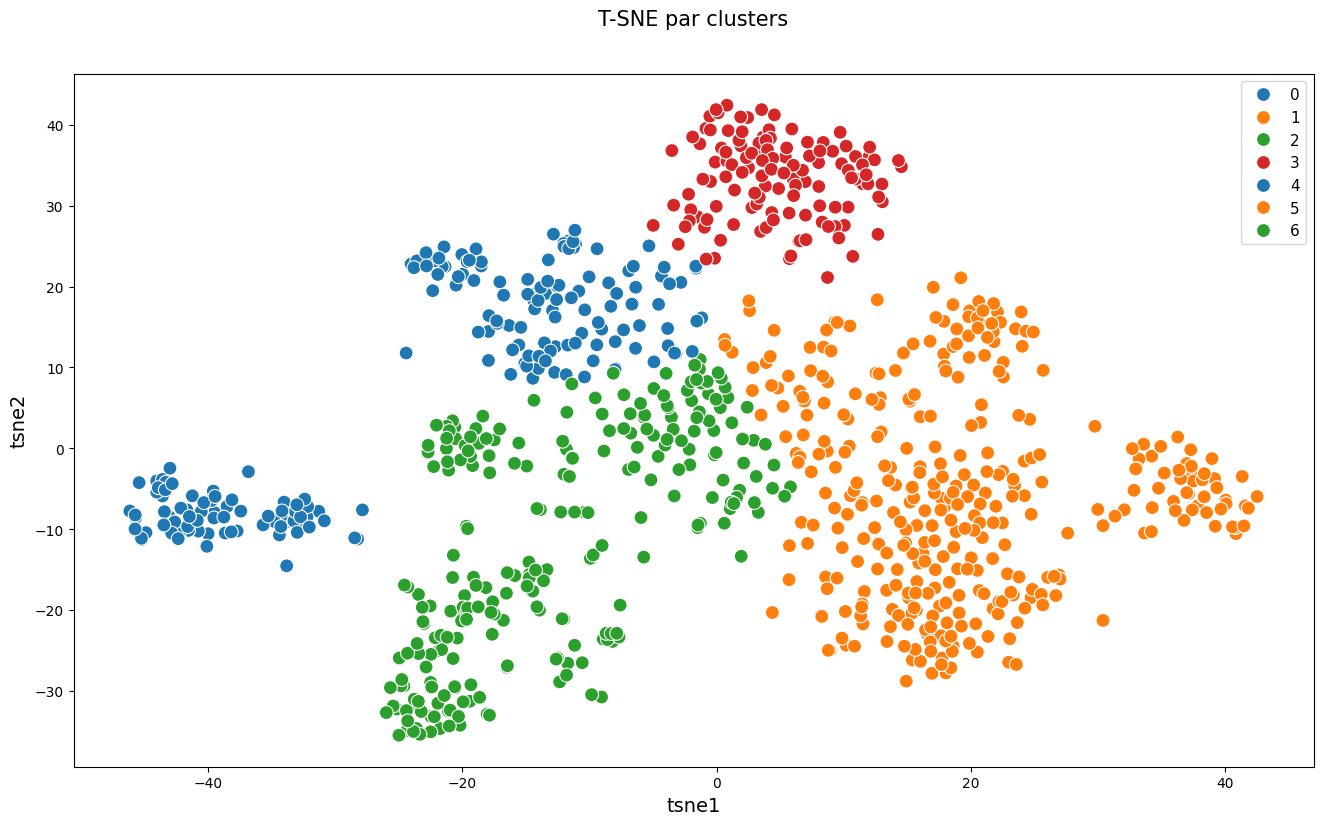

In [ ]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=100, alpha=1)

plt.title('T-SNE par clusters', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11})

plt.show()

In [ ]:
labels = train_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.5577919497409749


### Apprentissage supervisé avec CNN transfer learning

In [ ]:
#Création des modèles de classification

def create_VGG16_fct() :
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

In [ ]:
def create_VGG16_fct2() :
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),])

    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')])

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
def create_VGG19_fct():
    model0 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
def create_ResNet50_fct():
    model0 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=model0.input, outputs=predictions)

    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    print(model.summary())
    return model

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np_train = image_prep_fct(train_data)
print(images_np_train.shape)

images_np_test = image_prep_fct(test_data)
print(images_np_test.shape)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(945, 224, 224, 3)
(105, 224, 224, 3)


In [ ]:
y = to_categorical(train_data['label'])
y_test = to_categorical(test_data['label'])
X = images_np_train
X_test = images_np_test

In [ ]:
print(y.shape)
print(y_test.shape)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(945, 7)
(105, 7)


(708, 224, 224, 3)

### VGG16 Simplifié

**Création du modèle**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

with tf.device('/gpu:0'):
    model1 = create_VGG16_fct()

model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=8, batch_size=32,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3998 - loss: 7.7386
Epoch 1: val_loss improved from inf to 1.63588, saving model to ./model1_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 605ms/step - accuracy: 0.4055 - loss: 7.6117 - val_accuracy: 0.7131 - val_loss: 1.6359
Epoch 2/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7091 - loss: 1.5241
Epoch 2: val_loss improved from 1.63588 to 1.38231, saving model to ./model1_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7107 - loss: 1.5269 - val_accuracy: 0.7806 - val_loss: 1.3823
Epoch 3/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8056 - loss: 1.0518
Epoch 3: val_loss improved from 1.38231 to 1.22689, saving model to ./model1_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8069 - loss: 1.0460 - val_accuracy: 0.7932 - val_loss: 1.2269
Epoch 4/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8473 - loss: 0.6035
Epoch 4: val_loss improved 

**Scores**

In [ ]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9983 - loss: 0.0164
Training Accuracy: 0.9972

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8418 - loss: 0.9853
Validation Accuracy:  0.8354


In [ ]:
model1.load_weights(model1_save_path1)
loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8186
Test Accuracy       :  0.6190


In [ ]:
pip install plot_keras_history

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.39-py3-none-any.whl size=10667 sha256=3979757212db9e1539e4c116870e1d8b617487dec1a402677038c8ec381da09e
  Stored in directory: /root/.cache/pip/wheels/56/8d/d7/bd70289b1bd192664225cd608fd08437ecc725c3f8918383d9
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.1.4-py3-none-any.whl size=324285 sha256=3c90fdea018c8e83c0bc5fc4ba0996ddbcf1d813b1fcb3f2a4a30cd8461db1b7
  Stored in directory: /root/.cache/pip/wheels/ed/32/52/40db53b628215fe3c4fe7d0b0fe1decfd67ccccc91118df507
  Created wheel for compress-json: filename=compress_json-1.1.1-py3-none-any.whl size=6598 sha256=305483600421da044770910a6a0691c3bdd0672746d1423f4833dc5c7d7a4991
  Stored in directory: /root/.cache/pip/wheels/d3/7a/5f/bd24248a3baef

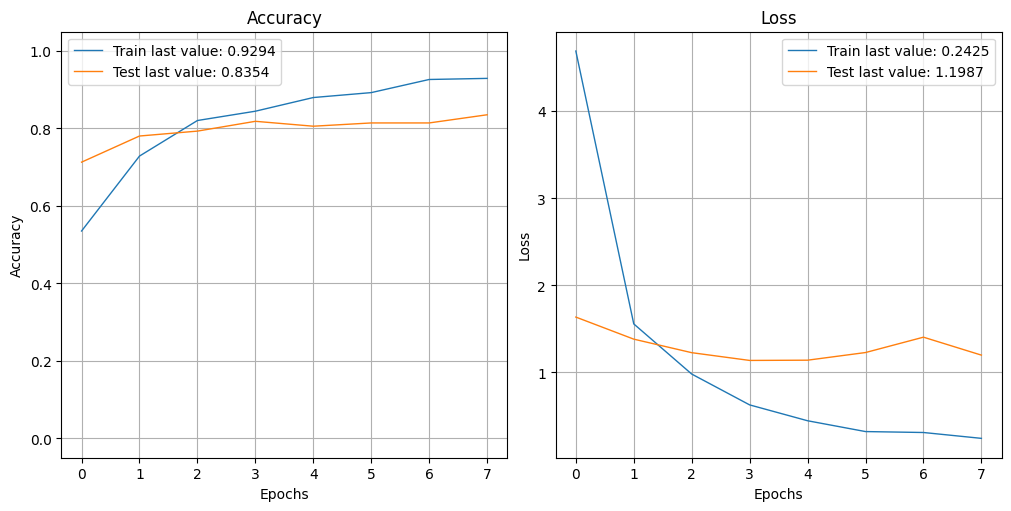

In [ ]:

from plot_keras_history import show_history, plot_history
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

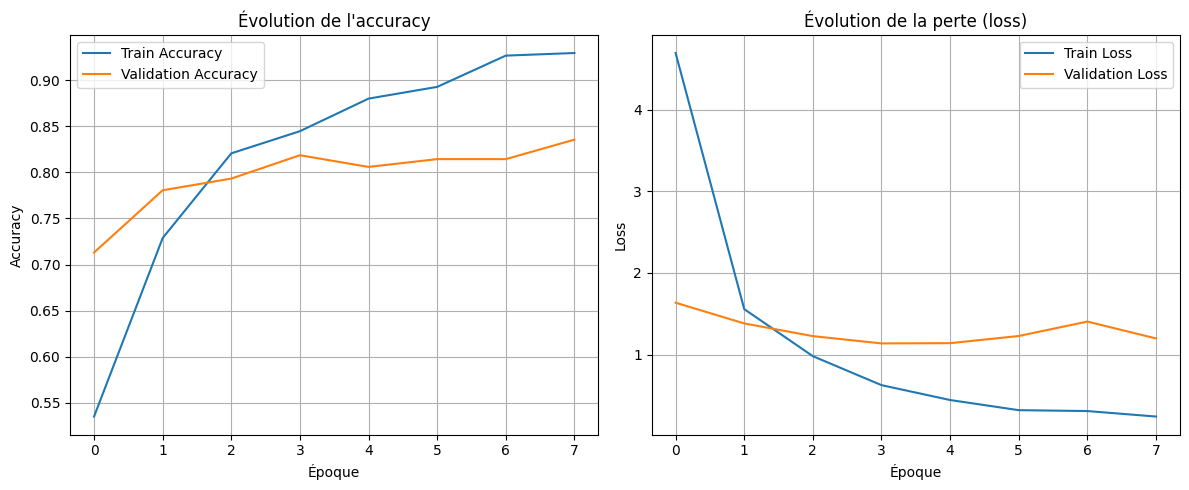

In [ ]:
import matplotlib.pyplot as plt

# 📈 Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Évolution de l\'accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 📉 Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la perte (loss)')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Analyse des catégories**

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step
[4 3 3 2 2 0 4 1 4 5 6 5 5 3 1 4 6 3 4 5 1 1 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 0 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 1 1 5 5 5 5 0 2 3 5
 1 1 4 3 6 1 4 2 2 5 0 3 6 1 5 4 2 3 3 4 3 3 3 5 3 3 0 5 3 1 4 5 3 1 5 4 3
 4 0 4 2 2 2 1 4 1 6 0 4 6 3 3 0 4 0 6 2 1 0 2 5 1 3 2 2 2 2 0 2 1 6 5 4 0
 0 4 1 0 6 0 6 6 5 1 3 1 6 3 2 6 1 4 5 6 4 3 4 6 0 4 0 3 6 3 4 2 1 3 6 5 2
 4 6 0 1 6 5 1 2 0 3 3 6 2 0 6 3 1 2 6 1 0 6 5 3 0 1 3 2 2 2 6 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 0 0 4 1 2 0 4]

[4 3 3 2 2 0 0 1 4 5 6 5 2 3 1 4 6 0 4 5 4 1 2 5 4 1 2 5 4 5 6 5 5 6 0 6 5
 3 4 0 5 6 3 4 3 1 6 5 4 1 2 4 6 0 5 3 2 2 0 4 6 1 5 4 6 1 3 5 5 5 0 2 3 3
 1 1 3 3 6 5 4 2 2 5 0 3 6 1 5 3 2 3 3 4 3 3 3 5 0 4 0 5 3 1 0 5 5 1 5 4 3
 4 0 0 2 2 2 4 4 1 6 4 0 6 3 3 2 4 0 6 5 1 0 2 5 3 3 2 2 2 4 0 2 1 6 3 4 5
 6 4 1 0 6 0 6 6 5 1 3 1 6 3 1 5 1 4 5 6 4 3 4 6 0 4 5 0 6 0 4 2 2 3 6 5 2
 4 6 0 2 6 5 1 2 3 3 3 6 2 4 6 3 2 2 6 1 0 6 5 3 0 3 3 2 2 2 6 6 1 4 4 2 1
 6 4 5 0 4 5 2 5 3 0 4 1 2 0

In [ ]:
def calculate_confusion_matrix(y_true, y_pred):
    categories = ["Baby Care", "Beauty and Personal Care", "Computers",
                  "Home Decor & Festive Needs", "Home Furnishing",
                  "Kitchen & Dining", "Watches"]

    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(conf_mat, index=[f'Actual {categories[i]}' for i in range(len(conf_mat))],
                               columns=[f'Predicted {categories[i]}' for i in range(len(conf_mat[0]))])

    classification_report = metrics.classification_report(y_true, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(classification_report).transpose()
    return conf_mat_df, class_report_df

In [ ]:
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


Predicted Baby Care  \
Actual Baby Care                                    21   
Actual Beauty and Personal Care                      0   
Actual Computers                                     0   
Actual Home Decor & Festive Needs                    4   
Actual Home Furnishing                               4   
Actual Kitchen & Dining                              0   
Actual Watches                                       0   

                                   Predicted Beauty and Personal Care  \
Actual Baby Care                                                    0   
Actual Beauty and Personal Care                                    25   
Actual Computers                                                    1   
Actual Home Decor & Festive Needs                                   0   
Actual Home Furnishing                                              0   
Actual Kitchen & Dining                                             0   
Actual Watches                                                      0   

                                   Predicted Computers  \
Actual Baby Care                                     1   
Actual Beauty and Personal Care                      3   
Actual Computers                                    30   
Actual Home Decor & Festive Needs                    0   
Actual Home Furnishing                               0   
Actual Kitchen & Dining                              1   
Actual Watches                                       0   

                                   Predicted Home Decor & Festive Needs  \
Actual Baby Care                                                      2   
Actual Beauty and Personal Care                                       2   
Actual Computers                                                      1   
Actual Home Decor & Festive Needs                                    28   
Actual Home Furnishing                                                2   
Actual Kitchen & Dining                                               3   
Actual Watches                                                        0   

                                   Predicted Home Furnishing  \
Actual Baby Care                                           6   
Actual Beauty and Personal Care                            2   
Actual Computers                                           1   
Actual Home Decor & Festive Needs                          1   
Actual Home Furnishing                                    28   
Actual Kitchen & Dining                                    0   
Actual Watches                                             0   

                                   Predicted Kitchen & Dining  \
Actual Baby Care                                            3   
Actual Beauty and Personal Care                             1   
Actual Computers                                            1   
Actual Home Decor & Festive Needs                           1   
Actual Home Furnishing                                      0   
Actual Kitchen & Dining                                    30   
Actual Watches                                              1   

                                   Predicted Watches  
Actual Baby Care                                   1  
Actual Beauty and Personal Care                    1  
Actual Computers                                   0  
Actual Home Decor & Festive Needs                  0  
Actual Home Furnishing                             0  
Actual Kitchen & Dining                            0  
Actual Watches                                    32

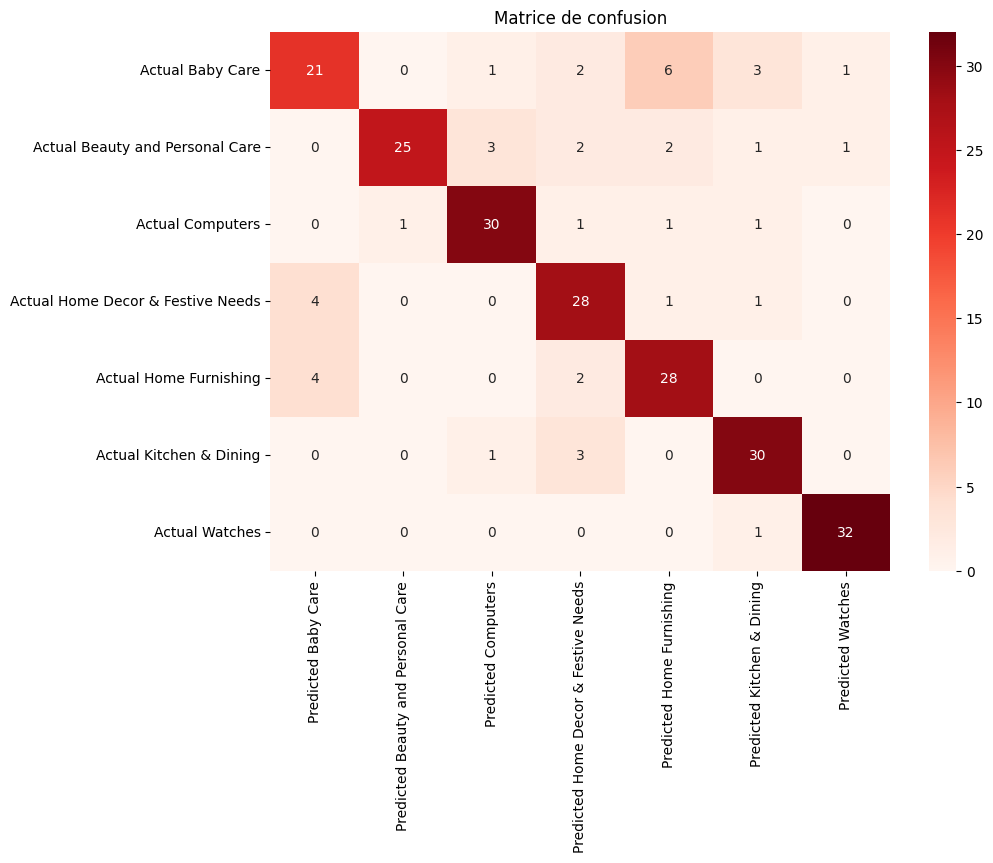

Rapport de classification :


precision    recall  f1-score     support
0              0.724138  0.617647  0.666667   34.000000
1              0.961538  0.735294  0.833333   34.000000
2              0.857143  0.882353  0.869565   34.000000
3              0.736842  0.823529  0.777778   34.000000
4              0.736842  0.823529  0.777778   34.000000
5              0.810811  0.882353  0.845070   34.000000
6              0.941176  0.969697  0.955224   33.000000
accuracy       0.818565  0.818565  0.818565    0.818565
macro avg      0.824070  0.819200  0.817916  237.000000
weighted avg   0.823576  0.818565  0.817337  237.000000

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

print("Rapport de classification :")
classification_report_df

### VGG16 : Image data generator avec augmentation des données

**Préparation**

In [ ]:
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
batch_size = 32
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type)
    return data_flow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)
train_flow = data_flow_fct(train_data, datagen_train, data_type='training')
val_flow = data_flow_fct(train_data, datagen_train, data_type='validation')

Found 709 validated image filenames belonging to 7 classes.
Found 236 validated image filenames belonging to 7 classes.


In [ ]:
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input)
test_flow = data_flow_fct(test_data, datagen_test)

Found 105 validated image filenames belonging to 7 classes.


**Création du modèle**

In [ ]:
with tf.device('/gpu:0'):
    model2 = create_VGG16_fct()

model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,epochs=8, batch_size=batch_size,
                       callbacks=callbacks_list, validation_data=val_flow, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.3115 - loss: 6.8900

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.23833, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3166 - loss: 6.7927 - val_accuracy: 0.7415 - val_loss: 1.2383
Epoch 2/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7270 - loss: 1.5458
Epoch 2: val_loss improved from 1.23833 to 1.01544, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 925ms/step - accuracy: 0.7263 - loss: 1.5499 - val_accuracy: 0.7881 - val_loss: 1.0154
Epoch 3/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.7621 - loss: 1.1585
Epoch 3: val_loss improved from 1.01544 to 0.92090, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 927ms/step - accuracy: 0.7626 - loss: 1.1541 - val_accuracy: 0.8136 - val_loss: 0.9209
Epoch 4/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7889 - loss: 0.8486
Epoch 4: val_loss improved from 0.92090 to 0.88636, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━

**Scores**

In [ ]:

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 730ms/step - accuracy: 0.9614 - loss: 0.1254
Training Accuracy   : 0.9605

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step - accuracy: 0.8142 - loss: 0.9632
Validation Accuracy :  0.8008


In [ ]:
model2.load_weights(model2_save_path)
loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8136
Test Accuracy       :  0.5333


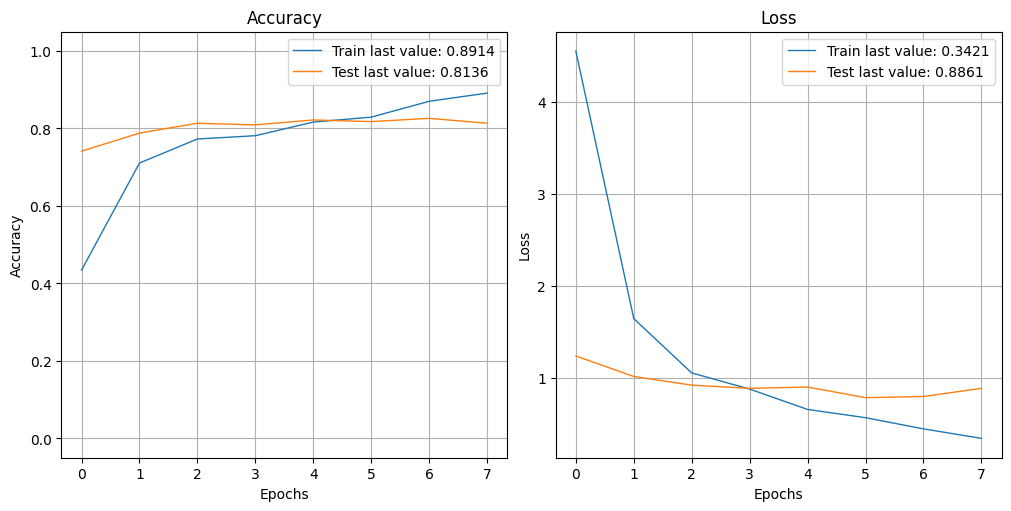

In [ ]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

**Analyse des catégories**

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model2.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step
[4 3 3 2 2 0 4 1 4 5 6 5 5 3 1 4 6 3 4 5 1 1 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 0 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 1 1 5 5 5 5 0 2 3 5
 1 1 4 3 6 1 4 2 2 5 0 3 6 1 5 4 2 3 3 4 3 3 3 5 3 3 0 5 3 1 4 5 3 1 5 4 3
 4 0 4 2 2 2 1 4 1 6 0 4 6 3 3 0 4 0 6 2 1 0 2 5 1 3 2 2 2 2 0 2 1 6 5 4 0
 0 4 1 0 6 0 6 6 5 1 3 1 6 3 2 6 1 4 5 6 4 3 4 6 0 4 0 3 6 3 4 2 1 3 6 5 2
 4 6 0 1 6 5 1 2 0 3 3 6 2 0 6 3 1 2 6 1 0 6 5 3 0 1 3 2 2 2 6 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 0 0 4 1 2 0 4]

[4 3 3 2 2 0 0 1 4 5 6 5 5 3 1 4 6 3 4 5 0 1 2 5 4 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 4 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 3 2 2 0 4 6 1 5 4 6 1 5 5 5 5 0 2 3 5
 1 1 1 3 6 1 4 2 2 5 0 3 6 1 5 4 2 3 3 4 3 3 3 5 3 3 0 5 3 1 0 5 3 1 5 4 3
 4 0 0 2 2 2 1 4 1 6 0 0 6 3 3 0 0 0 6 2 1 0 2 5 1 3 2 2 2 3 0 2 1 6 5 4 5
 6 4 1 0 6 0 6 6 5 1 5 1 6 3 2 1 1 4 5 6 4 3 0 6 0 4 5 0 6 3 4 2 2 3 6 5 2
 4 6 0 1 6 5 1 2 3 3 3 6 2 4 6 3 2 2 6 1 0 6 5 3 0 3 3 2 2 2 3 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 3 0 4 1 2 0

In [ ]:
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


Predicted Baby Care  \
Actual Baby Care                                    26   
Actual Beauty and Personal Care                      1   
Actual Computers                                     0   
Actual Home Decor & Festive Needs                    1   
Actual Home Furnishing                               6   
Actual Kitchen & Dining                              0   
Actual Watches                                       0   

                                   Predicted Beauty and Personal Care  \
Actual Baby Care                                                    0   
Actual Beauty and Personal Care                                    29   
Actual Computers                                                    0   
Actual Home Decor & Festive Needs                                   0   
Actual Home Furnishing                                              1   
Actual Kitchen & Dining                                             0   
Actual Watches                                                      1   

                                   Predicted Computers  \
Actual Baby Care                                     0   
Actual Beauty and Personal Care                      2   
Actual Computers                                    32   
Actual Home Decor & Festive Needs                    0   
Actual Home Furnishing                               0   
Actual Kitchen & Dining                              0   
Actual Watches                                       0   

                                   Predicted Home Decor & Festive Needs  \
Actual Baby Care                                                      2   
Actual Beauty and Personal Care                                       1   
Actual Computers                                                      2   
Actual Home Decor & Festive Needs                                    32   
Actual Home Furnishing                                                0   
Actual Kitchen & Dining                                               0   
Actual Watches                                                        1   

                                   Predicted Home Furnishing  \
Actual Baby Care                                           3   
Actual Beauty and Personal Care                            0   
Actual Computers                                           0   
Actual Home Decor & Festive Needs                          0   
Actual Home Furnishing                                    27   
Actual Kitchen & Dining                                    0   
Actual Watches                                             0   

                                   Predicted Kitchen & Dining  \
Actual Baby Care                                            2   
Actual Beauty and Personal Care                             0   
Actual Computers                                            0   
Actual Home Decor & Festive Needs                           1   
Actual Home Furnishing                                      0   
Actual Kitchen & Dining                                    34   
Actual Watches                                              0   

                                   Predicted Watches  
Actual Baby Care                                   1  
Actual Beauty and Personal Care                    1  
Actual Computers                                   0  
Actual Home Decor & Festive Needs                  0  
Actual Home Furnishing                             0  
Actual Kitchen & Dining                            0  
Actual Watches                                    31

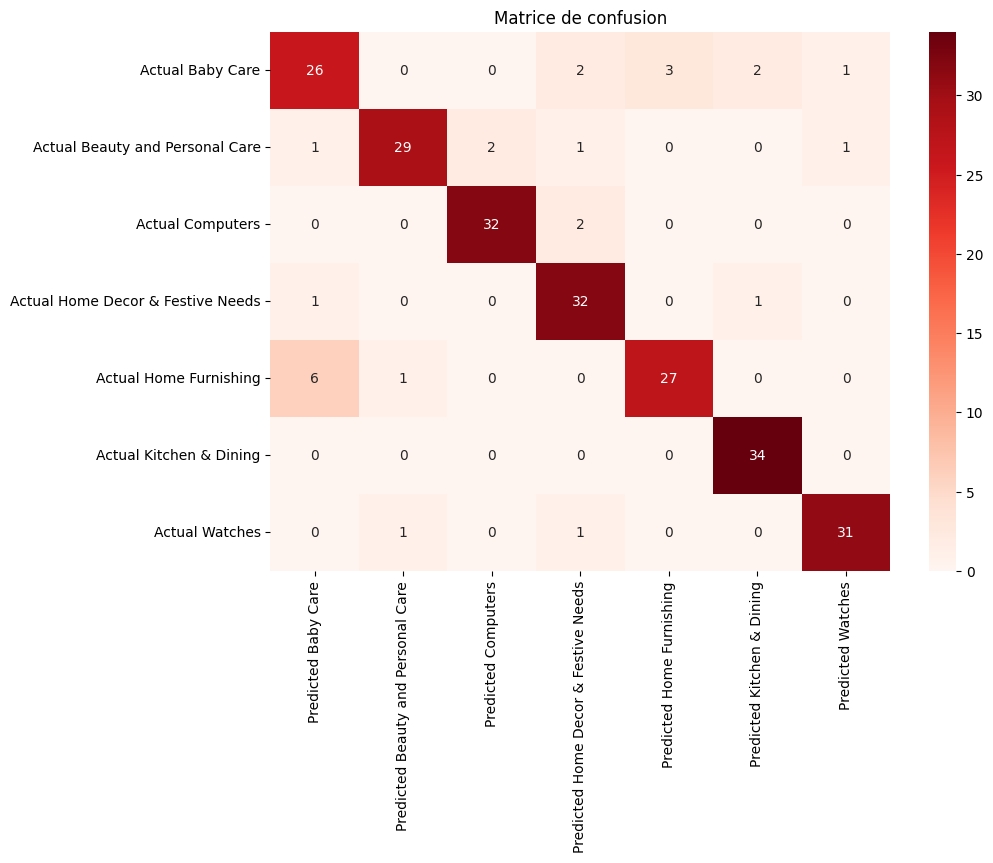

Rapport de classification :


precision    recall  f1-score     support
0              0.764706  0.764706  0.764706   34.000000
1              0.935484  0.852941  0.892308   34.000000
2              0.941176  0.941176  0.941176   34.000000
3              0.842105  0.941176  0.888889   34.000000
4              0.900000  0.794118  0.843750   34.000000
5              0.918919  1.000000  0.957746   34.000000
6              0.939394  0.939394  0.939394   33.000000
accuracy       0.890295  0.890295  0.890295    0.890295
macro avg      0.891683  0.890502  0.889710  237.000000
weighted avg   0.891482  0.890295  0.889500  237.000000

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

print("Rapport de classification :")
classification_report_df

### VGG19

**Création du modèle**

In [ ]:
from tensorflow.keras.applications import VGG19
with tf.device('/gpu:0'):
    model4 = create_VGG19_fct()
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [ ]:
batch_size = 32
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type)
    return dataset

In [ ]:
train_path = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/train'
test_path = '/content/drive/MyDrive/Projet 6 : Classifier automatiquement des biens de consommations/Datacat/test'
dataset_train = dataset_fct(train_path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(train_path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(test_path, validation_split=0, data_type=None)

Found 945 files belonging to 7 classes.
Using 709 files for training.
Found 945 files belonging to 7 classes.
Using 236 files for validation.
Found 105 files belonging to 7 classes.


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=8, callbacks=callbacks_list, verbose=1)

Num GPUs Available:  1
Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3726 - loss: 8.2835
Epoch 1: val_loss improved from inf to 1.13073, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.3775 - loss: 8.1686 - val_accuracy: 0.8178 - val_loss: 1.1307
Epoch 2/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6661 - loss: 2.4072
Epoch 2: val_loss improved from 1.13073 to 1.07082, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.6682 - loss: 2.3953 - val_accuracy: 0.7839 - val_loss: 1.0708
Epoch 3/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7367 - loss: 1.5161
Epoch 3: val_loss improved from 1.07082 to 0.77933, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.7384 - loss: 1.5027 - val_accuracy: 0.8347 - val_loss: 0.7793
Epoch 4/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8262 - loss: 0.8092
Epoc

In [ ]:
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9889 - loss: 0.0349
Training Accuracy   : 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8759 - loss: 0.5572 
Validation Accuracy :  0.8475


In [ ]:
model4.load_weights(model4_save_path)
loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8390
Test Accuracy       :  0.5810


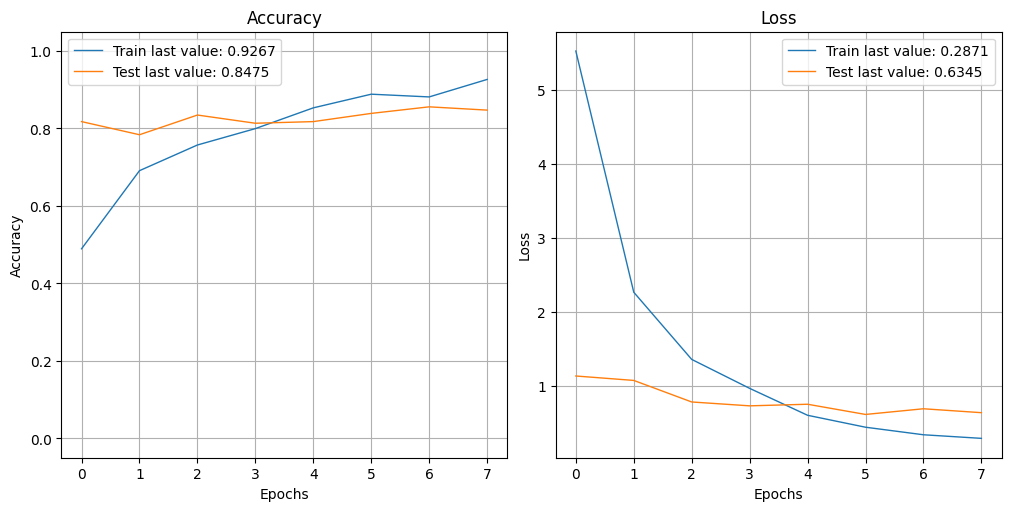

In [ ]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [ ]:
y_val_pred = np.argmax(model4.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step
[4 3 3 2 2 0 4 1 4 5 6 5 5 3 1 4 6 3 4 5 1 1 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 0 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 1 1 5 5 5 5 0 2 3 5
 1 1 4 3 6 1 4 2 2 5 0 3 6 1 5 4 2 3 3 4 3 3 3 5 3 3 0 5 3 1 4 5 3 1 5 4 3
 4 0 4 2 2 2 1 4 1 6 0 4 6 3 3 0 4 0 6 2 1 0 2 5 1 3 2 2 2 2 0 2 1 6 5 4 0
 0 4 1 0 6 0 6 6 5 1 3 1 6 3 2 6 1 4 5 6 4 3 4 6 0 4 0 3 6 3 4 2 1 3 6 5 2
 4 6 0 1 6 5 1 2 0 3 3 6 2 0 6 3 1 2 6 1 0 6 5 3 0 1 3 2 2 2 6 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 0 0 4 1 2 0 4]

[4 3 3 2 3 0 0 1 4 5 6 5 5 3 1 4 6 3 4 5 0 3 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 3 5 6 3 4 3 1 6 5 3 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 1 1 5 5 5 5 0 2 3 5
 1 1 1 3 6 1 4 2 2 5 0 3 6 1 5 3 2 3 3 4 3 3 3 5 0 3 0 5 3 1 4 5 3 1 5 4 3
 4 0 4 1 2 2 1 4 1 6 4 0 6 3 3 0 4 0 6 2 1 0 2 5 1 3 2 2 2 3 0 2 1 6 0 3 0
 3 4 1 0 6 0 6 6 5 1 5 1 6 3 1 6 1 0 5 6 4 3 4 6 0 4 0 0 6 0 4 2 1 3 6 5 2
 4 6 0 1 6 5 1 2 0 3 3 6 2 4 6 3 6 2 3 1 0 6 5 3 4 3 3 2 2 2 3 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 0 0 4 1 2 0

In [ ]:
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


Predicted Baby Care  \
Actual Baby Care                                    28   
Actual Beauty and Personal Care                      1   
Actual Computers                                     0   
Actual Home Decor & Festive Needs                    3   
Actual Home Furnishing                               3   
Actual Kitchen & Dining                              1   
Actual Watches                                       0   

                                   Predicted Beauty and Personal Care  \
Actual Baby Care                                                    0   
Actual Beauty and Personal Care                                    30   
Actual Computers                                                    2   
Actual Home Decor & Festive Needs                                   0   
Actual Home Furnishing                                              1   
Actual Kitchen & Dining                                             0   
Actual Watches                                                      0   

                                   Predicted Computers  \
Actual Baby Care                                     0   
Actual Beauty and Personal Care                      0   
Actual Computers                                    30   
Actual Home Decor & Festive Needs                    0   
Actual Home Furnishing                               0   
Actual Kitchen & Dining                              0   
Actual Watches                                       0   

                                   Predicted Home Decor & Festive Needs  \
Actual Baby Care                                                      2   
Actual Beauty and Personal Care                                       2   
Actual Computers                                                      2   
Actual Home Decor & Festive Needs                                    30   
Actual Home Furnishing                                                3   
Actual Kitchen & Dining                                               0   
Actual Watches                                                        2   

                                   Predicted Home Furnishing  \
Actual Baby Care                                           4   
Actual Beauty and Personal Care                            0   
Actual Computers                                           0   
Actual Home Decor & Festive Needs                          0   
Actual Home Furnishing                                    27   
Actual Kitchen & Dining                                    0   
Actual Watches                                             0   

                                   Predicted Kitchen & Dining  \
Actual Baby Care                                            0   
Actual Beauty and Personal Care                             0   
Actual Computers                                            0   
Actual Home Decor & Festive Needs                           1   
Actual Home Furnishing                                      0   
Actual Kitchen & Dining                                    33   
Actual Watches                                              0   

                                   Predicted Watches  
Actual Baby Care                                   0  
Actual Beauty and Personal Care                    1  
Actual Computers                                   0  
Actual Home Decor & Festive Needs                  0  
Actual Home Furnishing                             0  
Actual Kitchen & Dining                            0  
Actual Watches                                    31

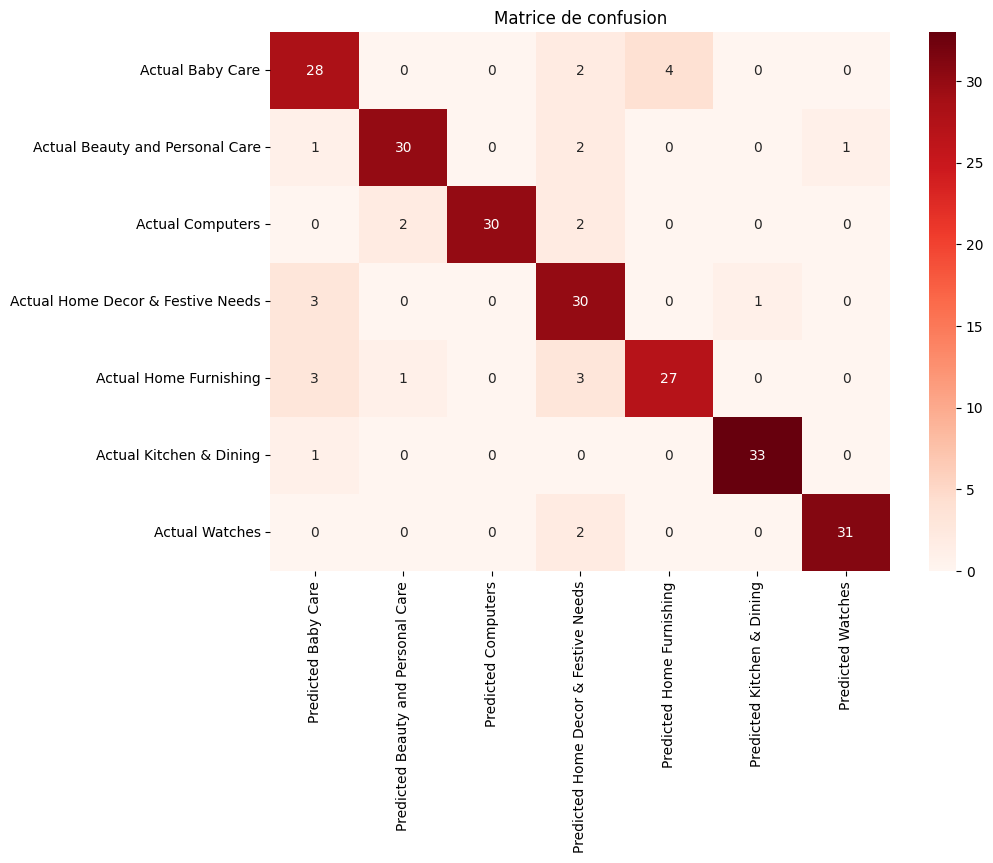

Rapport de classification :


precision    recall  f1-score     support
0              0.777778  0.823529  0.800000   34.000000
1              0.909091  0.882353  0.895522   34.000000
2              1.000000  0.882353  0.937500   34.000000
3              0.731707  0.882353  0.800000   34.000000
4              0.870968  0.794118  0.830769   34.000000
5              0.970588  0.970588  0.970588   34.000000
6              0.968750  0.939394  0.953846   33.000000
accuracy       0.881857  0.881857  0.881857    0.881857
macro avg      0.889840  0.882098  0.884032  237.000000
weighted avg   0.889507  0.881857  0.883738  237.000000

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

print("Rapport de classification :")
classification_report_df

### RESETNET 50

In [ ]:
from tensorflow.keras.applications import ResNet50


In [ ]:
with tf.device('/gpu:0'):
    model5 = create_ResNet50_fct()
model5_save_path = "./model5_best_weights.keras"
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/gpu:0'):
    history5 = model5.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=8, callbacks=callbacks_list, verbose=1)

Num GPUs Available:  1
Epoch 1/8
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8695 - loss: 0.3768
Epoch 1: val_loss did not improve from 0.43440
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8700 - loss: 0.3740 - val_accuracy: 0.7839 - val_loss: 0.8831
Epoch 2/8
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9075 - loss: 0.2657
Epoch 2: val_loss did not improve from 0.43440
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9058 - loss: 0.2729 - val_accuracy: 0.7839 - val_loss: 0.6047
Epoch 3/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9157 - loss: 0.2580
Epoch 3: val_loss did not improve from 0.43440
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9159 - loss: 0.2583 - val_accuracy: 0.8475 - val_loss: 0.5393
Epoch 4/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9152 - loss: 0.2245
Epoch 4: val_loss did not improve from 0.43440
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9151 - loss: 0.2249 - val_accuracy: 0.8856 - val_lo

In [ ]:
model5.load_weights(model5_save_path)

loss, accuracy = model5.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model5.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8644
Test Accuracy       :  0.6095


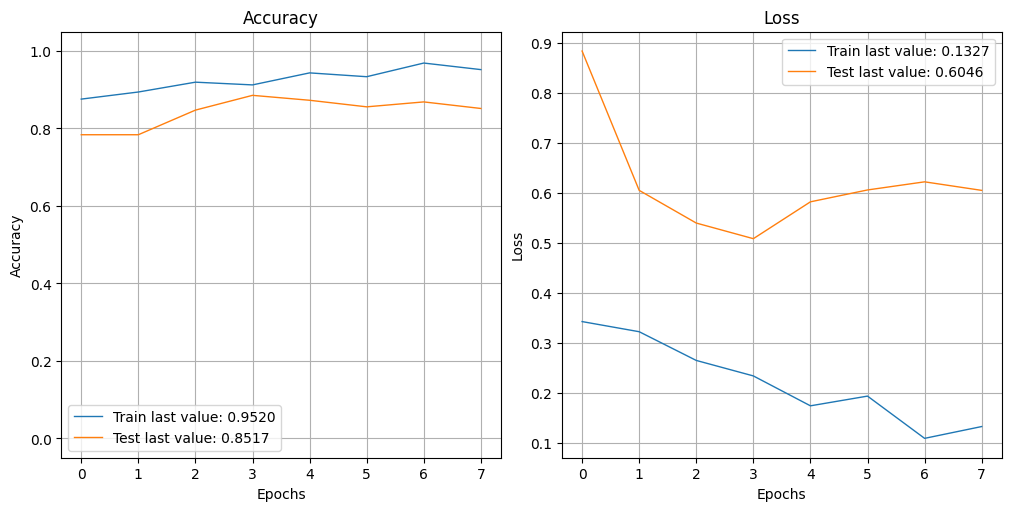

In [ ]:
show_history(history5)
plot_history(history5, path="standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model5.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[4 3 3 2 2 0 4 1 4 5 6 5 5 3 1 4 6 3 4 5 1 1 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 0 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 1 1 5 5 5 5 0 2 3 5
 1 1 4 3 6 1 4 2 2 5 0 3 6 1 5 4 2 3 3 4 3 3 3 5 3 3 0 5 3 1 4 5 3 1 5 4 3
 4 0 4 2 2 2 1 4 1 6 0 4 6 3 3 0 4 0 6 2 1 0 2 5 1 3 2 2 2 2 0 2 1 6 5 4 0
 0 4 1 0 6 0 6 6 5 1 3 1 6 3 2 6 1 4 5 6 4 3 4 6 0 4 0 3 6 3 4 2 1 3 6 5 2
 4 6 0 1 6 5 1 2 0 3 3 6 2 0 6 3 1 2 6 1 0 6 5 3 0 1 3 2 2 2 6 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 0 0 4 1 2 0 4]

[4 3 3 2 2 0 0 1 4 5 6 5 5 3 1 4 6 3 4 5 0 1 2 5 4 1 2 5 4 5 6 5 5 6 0 6 5
 3 4 0 5 6 3 4 3 1 6 5 5 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 6 1 5 5 5 1 6 2 3 5
 1 1 0 3 6 1 4 2 2 5 0 3 3 1 5 3 2 3 3 4 3 3 3 5 0 3 0 5 3 1 4 5 5 1 5 4 3
 4 0 4 2 2 2 4 4 1 6 4 4 6 3 3 3 4 0 6 2 1 0 2 1 1 3 2 2 2 3 0 1 1 6 3 3 5
 3 4 1 0 6 5 6 6 5 1 5 1 6 3 2 6 1 4 5 6 4 3 4 6 0 4 3 0 6 3 4 2 1 5 6 5 2
 4 6 0 6 6 5 1 2 0 3 3 6 2 4 6 3 2 2 6 1 0 6 5 3 0 3 3 2 2 2 6 6 1 4 4 2 1
 6 0 5 0 4 5 5 5 0 0 4 1 2 0 

In [ ]:
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


Predicted Baby Care  \
Actual Baby Care                                    22   
Actual Beauty and Personal Care                      1   
Actual Computers                                     0   
Actual Home Decor & Festive Needs                    2   
Actual Home Furnishing                               2   
Actual Kitchen & Dining                              0   
Actual Watches                                       0   

                                   Predicted Beauty and Personal Care  \
Actual Baby Care                                                    0   
Actual Beauty and Personal Care                                    28   
Actual Computers                                                    1   
Actual Home Decor & Festive Needs                                   0   
Actual Home Furnishing                                              0   
Actual Kitchen & Dining                                             2   
Actual Watches                                                      0   

                                   Predicted Computers  \
Actual Baby Care                                     0   
Actual Beauty and Personal Care                      1   
Actual Computers                                    31   
Actual Home Decor & Festive Needs                    0   
Actual Home Furnishing                               0   
Actual Kitchen & Dining                              0   
Actual Watches                                       0   

                                   Predicted Home Decor & Festive Needs  \
Actual Baby Care                                                      3   
Actual Beauty and Personal Care                                       1   
Actual Computers                                                      1   
Actual Home Decor & Festive Needs                                    29   
Actual Home Furnishing                                                2   
Actual Kitchen & Dining                                               1   
Actual Watches                                                        1   

                                   Predicted Home Furnishing  \
Actual Baby Care                                           5   
Actual Beauty and Personal Care                            1   
Actual Computers                                           0   
Actual Home Decor & Festive Needs                          0   
Actual Home Furnishing                                    29   
Actual Kitchen & Dining                                    0   
Actual Watches                                             0   

                                   Predicted Kitchen & Dining  \
Actual Baby Care                                            3   
Actual Beauty and Personal Care                             0   
Actual Computers                                            1   
Actual Home Decor & Festive Needs                           3   
Actual Home Furnishing                                      1   
Actual Kitchen & Dining                                    31   
Actual Watches                                              0   

                                   Predicted Watches  
Actual Baby Care                                   1  
Actual Beauty and Personal Care                    2  
Actual Computers                                   0  
Actual Home Decor & Festive Needs                  0  
Actual Home Furnishing                             0  
Actual Kitchen & Dining                            0  
Actual Watches                                    32

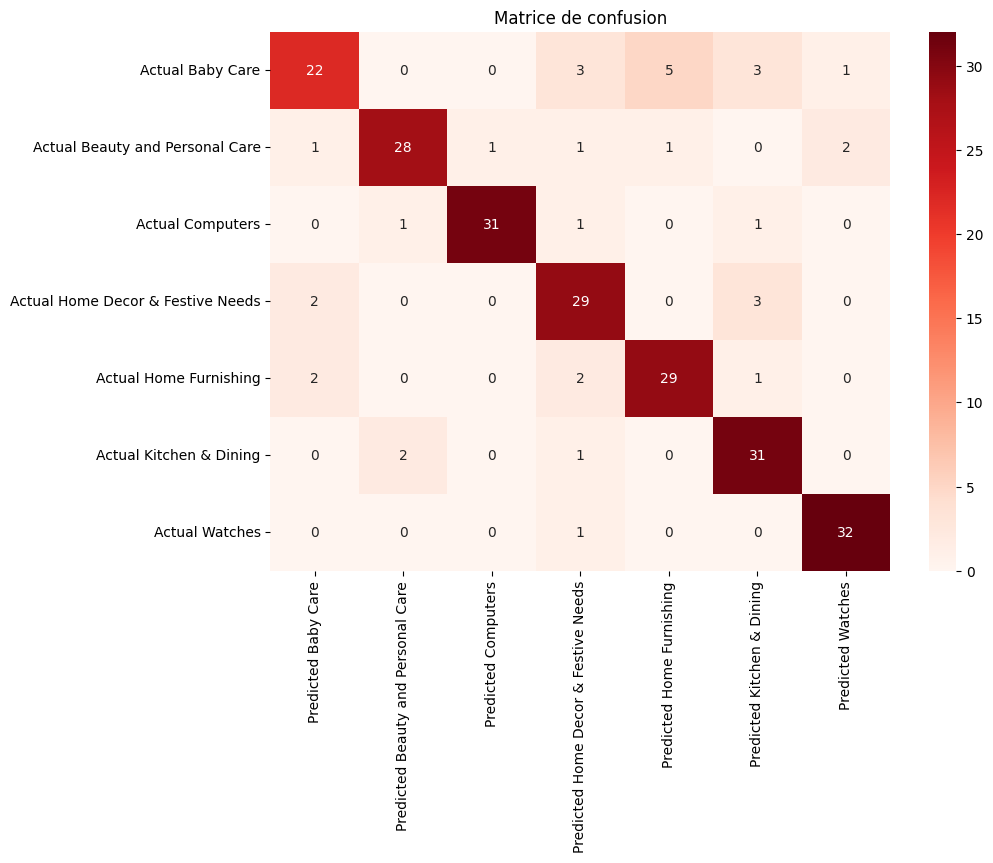

Rapport de classification :


precision    recall  f1-score     support
0              0.814815  0.647059  0.721311   34.000000
1              0.903226  0.823529  0.861538   34.000000
2              0.968750  0.911765  0.939394   34.000000
3              0.763158  0.852941  0.805556   34.000000
4              0.828571  0.852941  0.840580   34.000000
5              0.794872  0.911765  0.849315   34.000000
6              0.914286  0.969697  0.941176   33.000000
accuracy       0.852321  0.852321  0.852321    0.852321
macro avg      0.855382  0.852814  0.851267  237.000000
weighted avg   0.855134  0.852321  0.850888  237.000000

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

print("Rapport de classification :")
classification_report_df

### SIFT

La scale-invariant feature transform (SIFT), que l'on peut traduire par « transformation de caractéristiques visuelles invariante à l'échelle », est un algorithme utilisé dans le domaine de la vision par ordinateur pour détecter et identifier les éléments similaires entre différentes images numériques

cv2 est le module principal d’OpenCV qui fournit aux développeurs une interface facile à utiliser pour travailler avec les fonctions de traitement d’images et de vidéos.

In [17]:
import cv2

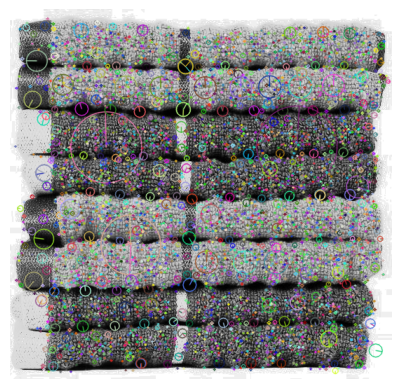

Descripteurs :  (5700, 128)

[[ 90.   5.   0. ...   0.   0.   5.]
 [115.  94.   6. ...  37.  45.  12.]
 [ 78.  87.   5. ...   0.   4.  11.]
 ...
 [ 33. 160.  21. ...   2.   2.   2.]
 [ 36. 151.  82. ...   6.   2.   1.]
 [ 44.  94. 152. ...   0.   0.   0.]]


In [18]:
if len(train_data) > 0:
    image_path = train_data["image_path"][99]
    image = cv2.imread(image_path, 0)
    image = cv2.equalizeHist(image)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    if des is not None:
        print("Descripteurs : ", des.shape)
        print()
        print(des)
    else:
        print("Aucun descripteur trouvé.")
else:
    print("Aucune image trouvée dans le DataFrame.")

In [31]:
import time

In [32]:
sift = cv2.SIFT_create(500)
sift_keypoints = []
temps1 = time.time()

for idx in range(len(train_data)):
    if idx % 100 == 0:
        print(idx)

    image_path = train_data['image_path'][idx]
    image = cv2.imread(image_path, 0)
    res = cv2.equalizeHist(image)

    kp, des = sift.detectAndCompute(res, None)
    if des is not None:
        sift_keypoints.append(des)


sift_keypoints_by_img = [des for des in sift_keypoints if des is not None]
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)

print("\nNombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900

Nombre de descripteurs :  (465413, 128)
Temps de traitement SIFT descriptor :  577.89 secondes


In [22]:
from sklearn import cluster, metrics


In [33]:
if 'sift_keypoints_all' in locals() and len(sift_keypoints_all) > 0:

    temps1 = time.time()
    k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
    print("Nombre de clusters estimés : ", k)
    print("Création de", k, "clusters de descripteurs ...")

    kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
    kmeans.fit(sift_keypoints_all)

    duration1 = time.time() - temps1
    print("Temps de traitement KMeans : ", "{:.2f}".format(duration1), "secondes")
else:
    print("Aucun descripteur SIFT n'a été trouvé. Veuillez d'abord exécuter le script de génération des descripteurs SIFT.")

Nombre de clusters estimés :  682
Création de 682 clusters de descripteurs ...
Temps de traitement KMeans :  3.00 secondes


In [34]:
#Création de variable d'image

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("Problème histogramme image : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

temps1 = time.time()

hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    if image_desc is not None:
        hist = build_histogram(kmeans, image_desc, i)
        hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900
Temps de création des histogrammes :  1.42 secondes


In [25]:
from sklearn import manifold, decomposition


In [35]:
#Réduction des dimensions PCA TSNE

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = train_data["label_name"]
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (945, 682)
Dimensions dataset après réduction PCA :  (945, 462)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(945, 3)


In [36]:
df_tsne

tsne1      tsne2            class
0    -2.417721   6.788545  Home Furnishing
1    15.894444  12.687796  Home Furnishing
2    11.360363  15.080256  Home Furnishing
3   -27.798065   3.675741  Home Furnishing
4   -21.103905  -6.658172  Home Furnishing
..         ...        ...              ...
940  12.830221  -0.402531        Computers
941  13.917952  -5.820518        Computers
942  -8.391768 -33.450928        Computers
943 -21.812716 -19.735310        Computers
944  -3.082844 -23.403940        Computers

[945 rows x 3 columns]

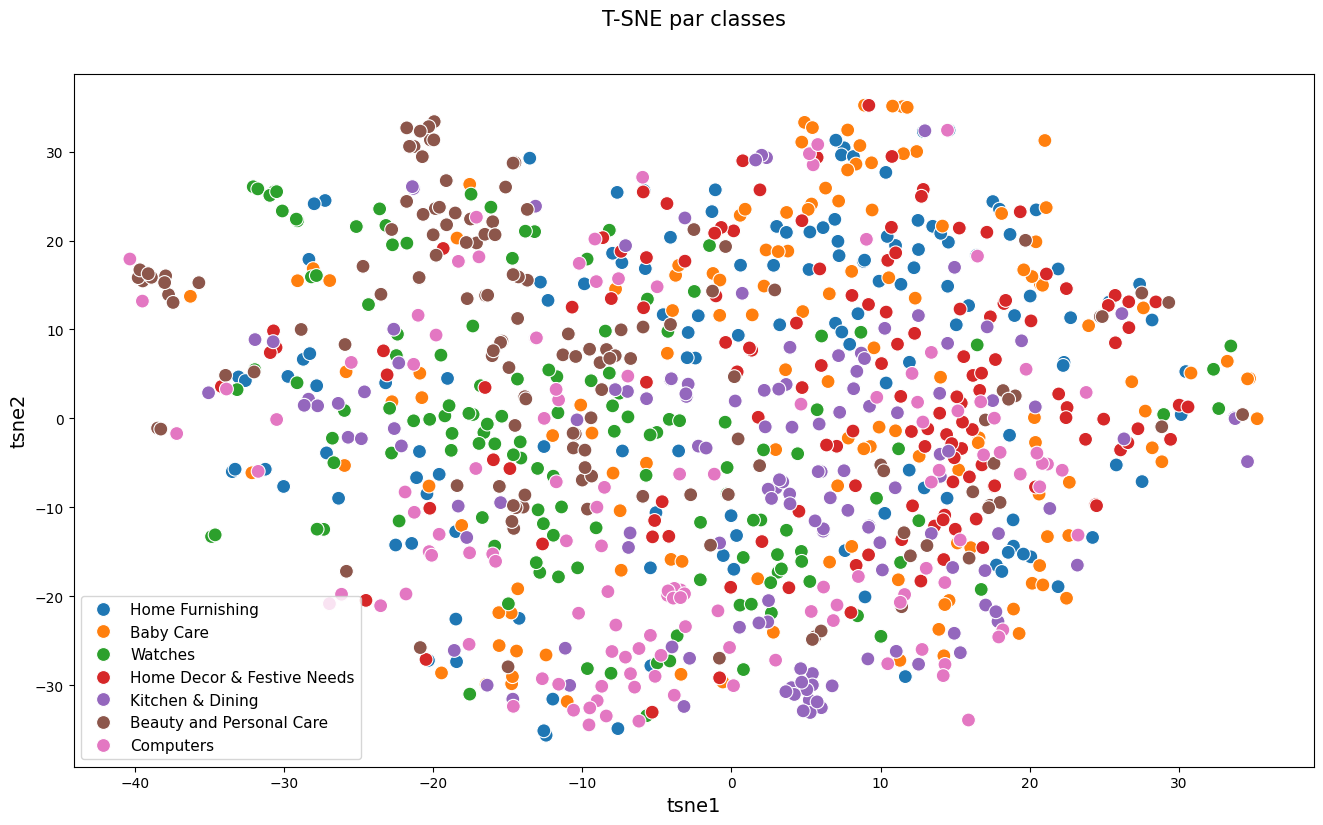

In [37]:
plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=100, alpha=1)

plt.title('T-SNE par classes', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11})

plt.show()

(945, 4)


<ipython-input-38-2c054585b0dc>:9: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


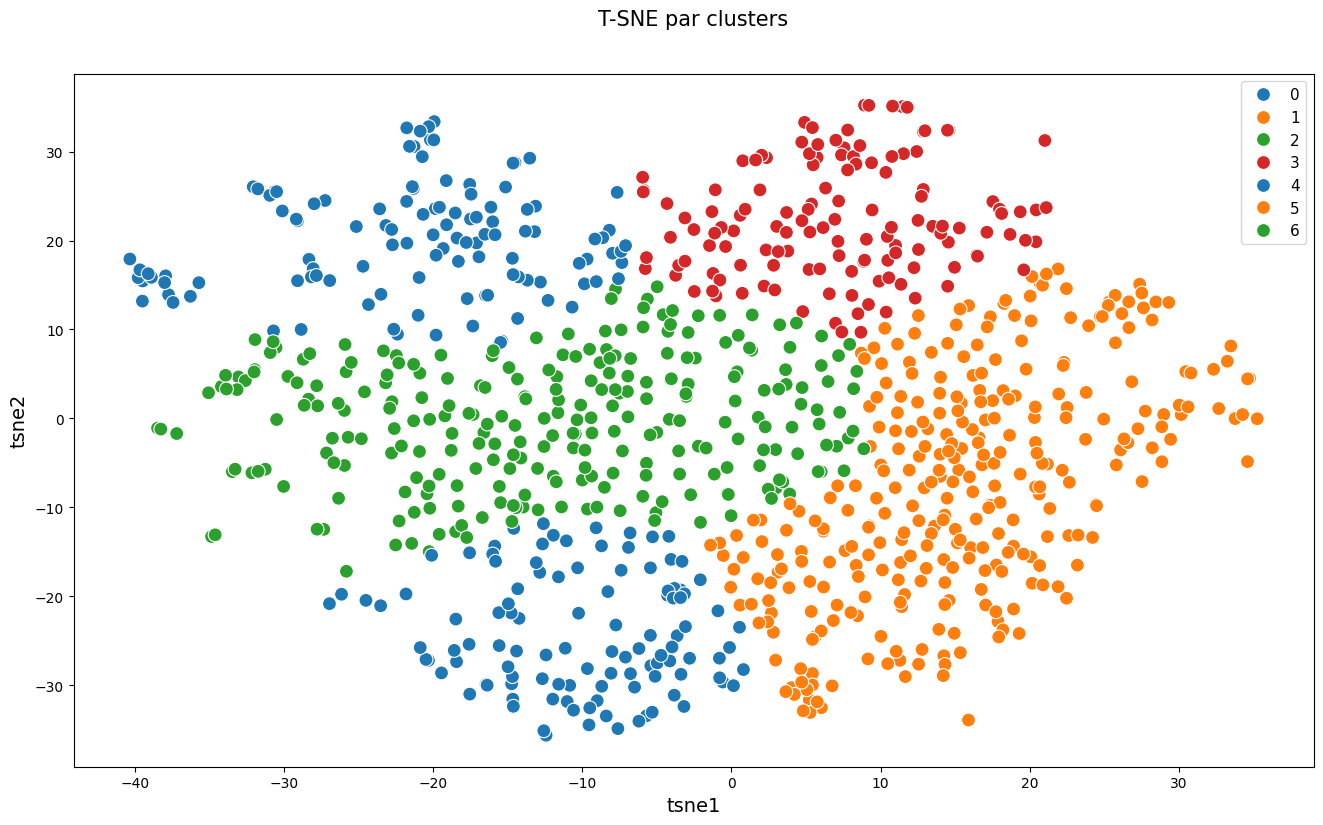

In [38]:
#Kmeans sur 2 composants TSNE

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)
plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=100, alpha=1)

plt.title('T-SNE par clusters', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11})

plt.show()

In [39]:
labels = train_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.06713381774872819


# Conclusion

Notre mission consistait à évaluer la faisabilité de la classification automatique des articles sur notre marketplace à partir des descriptions textuelles et des images. À travers ce projet, nous avons exploré diverses techniques dans le but d'analyser et de visualiser les données :  
 - Prétraitement des données
 - Extraction de features
 - Réduction dimensionnelle des données

 Les résultats obtenus nous permettront de déterminer si une telle automatisation est viable et comment elle pourrait améliorer l'expérience utilisateur.

 En conclusion, cette étude de faisabilité est une étape cruciale vers la mise en place d'un système de classification robuste et efficace, facilitant la mise en ligne des articles par les vendeurs et la recherche de produits par les acheteurs.